In [32]:
# N = N_up + N_down fermions in a harmonic trap, with delta function interaction

import os
import multiprocessing
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"
os.environ["JAX_ENABLE_X64"]="false"

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

import numpy as np
import time
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax
from jax import grad, hessian, jit, vmap
from jax.nn import celu
import gvar as gv
from functools import partial
from IPython.display import clear_output
import jax.example_libraries.optimizers as jax_opt
from tqdm import tqdm, trange
from math import factorial
import pickle
import csv

# set the default device to the cpu
# jax.default_device(jax.devices("cpu")[0])
jax.config.update('jax_platform_name', 'cpu')

#use pickle to save the parameters to a file 
def save_params(params, filename):
    with open(filename, 'wb') as f:
        pickle.dump(params, f)
# use pickle to dump the energies and uncertainties to a file
def save_energies(hs, us, filename):
    with open(filename, 'wb') as f:
        pickle.dump((hs, us), f)

def save_energies(h, u, filename):
    with open(filename,'a') as file:
        file.write(str(h)+","+str(u))
        file.write('\n')

# use pickle to load the parameters from a file
def load_params(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)    
# use pickle to load the energies and uncertainties from a file
def load_energies(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# using this data:
# 1, 0.0854344122657581
# 2, 0.12291311754684836
# 3, 0.15085178875638838
# 4, 0.1753833049403748
# 5, 0.1965076660988075
# 6, 0.21626916524701872
# 7, 0.23330494037478702
# 8, 0.2503407155025553
# 9, 0.2656729131175468

def compute_true_energy():
    ret = (N_up**2 + N_down**2)/2 
    if N_up == 1: 
        ret += 0.0854344122657581
    elif N_up == 2:
        ret += 0.12291311754684836
    elif N_up == 3:
        ret += 0.15085178875638838
    elif N_up == 4:
        ret += 0.1753833049403748
    elif N_up == 5:
        ret += 0.1965076660988075
    elif N_up == 6:
        ret += 0.21626916524701872
    elif N_up == 7:
        ret += 0.23330494037478702
    elif N_up == 8:
        ret += 0.2503407155025553
    elif N_up == 9:
        ret += 0.2656729131175468
    return ret


##### Constants
N_up = 3
N_down = 3
N = N_up + N_down

FACT_UP = 2 #increase this when N goes up
FACT_DOWN = 2 # increase this when N goes up
SYM_DEN = 3
GPU_INDEX = 1
# division factor in the ansatz
DIV = 2

INITIAL_SAMPLE = jnp.array(np.random.uniform(-2, 2, N))
phi_structure = [150,150]

m = 1
hbar = 1
omega = 1
harmonic_omega = 1
g = 0



#######

# this just gets the shapes of the weights and biases for a neural network with the given structure
def gen_weight_shapes(input_size, hidden_sizes, output_size):
    weights = []
    biases = []

    if hidden_sizes != [0]:
        sizes = [input_size] + hidden_sizes + [output_size]
    else:
        sizes = [input_size, output_size]
    for i in range(len(sizes) - 1):
        w = np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2/sizes[i])
        b = np.random.randn(1, sizes[i+1]) 
        weights.append(w)
        biases.append(b) 
    return weights, biases

# get the shapes
weight_shapes, bias_shapes = gen_weight_shapes(N, phi_structure, 1)

# generates a set of weights and biases for a neural network with the given structure
# returns a flattened array of the parameters

def gen_params(input_size, hidden_sizes, output_size):
    weights = []
    biases = []

    if hidden_sizes != [0]:
        sizes = [input_size] + hidden_sizes + [output_size]
    else:
        sizes = [input_size, output_size]
    for i in range(len(sizes) - 1):
            w = np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2/sizes[i])
            b = np.random.randn(1, sizes[i+1]) 
            weights.append(w)
            biases.append(b)
    return flatten_params(weights, biases) 

# calls the neural network with the given parameters and input
@jit
def nn(x, params):
    weights, biases = unflatten_params(params) 
    a = x
    for i in range(len(weights) - 1):
        z = jnp.dot(a, weights[i]) + biases[i]
        a = celu(z)
    a = jnp.dot(a, weights[-1]) + biases[-1]
    return a[0][0] 

# takes the weights and biases of a network and returns a flattened array of the parameters
@jit
def flatten_params(weights, biases):
    params = jnp.array([])
    for i in range(len(weights)):
        params = jnp.concatenate((params, weights[i].flatten()))
        params = jnp.concatenate((params, biases[i].flatten()))
    return jnp.array(params)

# takes a flattened array of parameters and returns the weights and biases of the network
@jit
def unflatten_params(params):
    weights = []
    biases = []
    start = 0
    for i in range(len(weight_shapes)):
        end = start + weight_shapes[i].size 
        weights.append(jnp.reshape(jnp.array(params[start:end]), weight_shapes[i].shape))
        start = end
        end = start + bias_shapes[i].size
        biases.append(jnp.reshape(jnp.array(params[start:end]), bias_shapes[i].shape))
        start = end
    return weights, biases



network = gen_params(N, phi_structure, 1)
# the length of the flattened parameters of a single particle neural network
phi_params_length = len(network)

# function that takes the coords, and moves coords[index] to the front of the list
@partial(jit, static_argnums=(1,))
def shift_coords(coords, index):
    return jnp.concatenate([jnp.array([coords[index]]), jnp.array(coords[:index]), jnp.array(coords[index + 1:])])

@partial(jit, static_argnums=(1,))
def inputs_up(coords, j):
    reordered = shift_coords(coords, j)
    sym_piece1 = reordered[1:N_up] / SYM_DEN
    sym_piece2 = reordered[N_up:] / SYM_DEN

    new1 = [jnp.sum(sym_piece1 ** i) for i in range(1, N_up)]
    new2 = [jnp.sum(sym_piece2 ** i) for i in range(1, N_down + 1)]
    
    return jnp.array([reordered[0]] + new1 + new2)

@partial(jit, static_argnums=(1,))
def inputs_down(coords, j):
    reordered = shift_coords(coords, j + N_up)
    
    sym_piece1 = reordered[1:N_up+1] / SYM_DEN
    sym_piece2 = reordered[N_up + 1:] / SYM_DEN
    
    new1 = [jnp.sum(sym_piece1 ** i) for i in range(1, N_up + 1)]
    new2 = [jnp.sum(sym_piece2 ** i) for i in range(1, N_down)]
    
    return jnp.array([reordered[0]] + new1 + new2)

@jit
def Phi_up(coords, params):
    # construct the matrix of outputs of the neural networks
    # take only the up spin coordinates
    mat = jnp.zeros((N_up, N_up))
    for i in range(N_up):
        ith_params = params[i * phi_params_length : (i + 1) * phi_params_length]
        for j in range(N_up): 
            mat = mat.at[i,j].set(nn(inputs_up(coords, j), ith_params))
    return jnp.linalg.det(mat) * FACT_UP 

@jit
def Phi_down(coords, params):
    # construct the matrix of outputs of the neural networks
    # take only the up spin coordinates
    mat = jnp.zeros((N_down, N_down))
    for i in range(N_down):
        temp = i + N_up
        ith_params = params[temp * phi_params_length : (temp + 1) * phi_params_length]
        for j in range(N_down): 
            mat = mat.at[i,j].set(nn(inputs_down(coords, j), ith_params))
    return jnp.linalg.det(mat)* FACT_DOWN

@jit
def psi(coords, params):
    return Phi_up(coords, params) * Phi_down(coords, params) * jnp.exp(-omega * jnp.sum((coords/DIV)**2))


@jit
def mcstep_E(xis, limit, positions, params):
    
#     params = jax.device_put(params, device=jax.devices("cpu")[0])
    
    newpositions = jnp.array(positions) + xis
    
    # prob = psi(newpositions, params)**2./psi(positions, params)**2.
    prob = (psi(newpositions, params)/psi(positions, params))**2.
    
    def truefunc(p):
        return [newpositions, True]

    def falsefunc(p):
        return [positions, False]
    
    return jax.lax.cond(prob >= limit, truefunc, falsefunc, prob)

def sample(params, Nsweeps, Ntherm, keep, stepsize, positions_initial=INITIAL_SAMPLE, progress=False):

    sq = []
    sq_prime = []
    counter = 0
    num_total = Nsweeps * keep + Ntherm + 1 
    rng = np.random.default_rng(int(time.time()))
    randoms = rng.uniform(-stepsize, stepsize, size = (num_total, N))
    limits = rng.uniform(0, 1, size = num_total)

    positions_prev = positions_initial
    
    if progress:
        for i in tqdm(range(0, num_total), position = 0, leave = True, desc = "MC"):
            
            new, moved = mcstep_E(randoms[i], limits[i], positions_prev, params)
        
            if moved:
                counter += 1
        
            if i%keep == 0 and i >= Ntherm:
                sq.append(new)
                
            positions_prev = new
                
    else: 
        for i in range(num_total):
            new, moved = mcstep_E(randoms[i], limits[i], positions_prev, params)
        
            if moved == True:
                counter += 1
                
            if i%keep == 0 and i >= Ntherm:
                #sq = np.vstack((sq, np.array(new)))
                sq.append(new)
                
            positions_prev = new
    # generate the primed samples by going through every sample and making sample[N_up] = sample[0]
    sq_prime = jnp.array(sq.copy())
    for i in range(len(sq)):
        a = jnp.array(sq[i])
        a = a.at[N_up].set(a[0])
        sq_prime = sq_prime.at[i].set(jnp.array(a))

    return jnp.array(sq), jnp.array(sq_prime), counter/num_total


psi_hessian = jax.jacfwd(jit(grad(psi, 0)), 0) # type: ignore

@jit
def ddpsi(coords, params):
    #return jnp.diagonal(A_hessian(transform(coords), params))
    return jnp.diag(psi_hessian(coords, params))


# derivative of the wavefunction with respect to the parameters
dnn_dtheta = jit(grad(psi, 1)) 
vdnn_dtheta = jit(vmap(dnn_dtheta, in_axes=(0, None), out_axes=0))


@jit
def Es_nodelta(coords, params):
    return - (1/2) * (1/ psi(coords, params)) * jnp.sum(ddpsi(coords, params)) + (1/2) * jnp.sum(coords**2) 

vEs_nodelta = jit(vmap(Es_nodelta, in_axes=(0,None), out_axes=0))

@jit
def Es_delta(coords, coords_prime, params, alpha, g):
    return N_up * N_down * g * (psi(coords_prime, params)**2)/(psi(coords, params)**2) * (1/(np.sqrt(np.pi)*alpha))*np.e**(-(coords[N_up]/alpha)**2)

vEs_delta = jit(vmap(Es_delta, in_axes=(0,0, None, None, None), out_axes=0))

@jit
def gradient_comp(coords, coords_prime, params, es_nodelta, energy_calc, es_delta):
    return 2/(psi(coords,params)) * dnn_dtheta(coords, params) * (es_nodelta - energy_calc) + 2/(psi(coords_prime, params)) * dnn_dtheta(coords_prime, params) * es_delta

vgradient_comp = jit(vmap(gradient_comp, in_axes=(0,0,None,0, None, 0), out_axes=0))

def accumulator_sample(params, Nsweeps, Ntherm, keep, stepsize, g, positions_initial=INITIAL_SAMPLE, progress=True):
    num_total = Nsweeps * keep + Ntherm + 1
#     params = jax.device_put(params, device=jax.devices("cpu")[0])

    randoms = np.random.uniform(-stepsize, stepsize, size=(num_total, N))
    limits = np.random.uniform(0, 1, size=num_total)

    accept_counter = 0
    es = 0
    grads = 0
    mean = 0
    m2 = 0
    alpha = 1

    positions_prev = positions_initial

    for i in range(num_total):
        new, moved = mcstep_E(randoms[i], limits[i], positions_prev, params)
        
        if i >= Ntherm and i % keep == 0:
            accept_counter += 1
            new_prime = np.copy(new)
            new_prime[N_up] = new_prime[0]

            temp_nodeltas = Es_nodelta(new, params)
            temp_deltas = Es_delta(new, new_prime, params, alpha, g)
            temp_sum = temp_nodeltas + temp_deltas

            es += temp_sum
            curr_e_avg = es / accept_counter
            grads += gradient_comp(new, new_prime, params, temp_nodeltas, curr_e_avg, temp_deltas)

            temp = temp_sum - mean
            mean += temp / accept_counter
            m2 += temp * (temp_sum - mean)

        positions_prev = new

    stddev = np.sqrt(m2 / (accept_counter - 1)) / jnp.sqrt(accept_counter)
    return es, grads, stddev

def accumulator_gradient(params, g, num_samples=10**3, thermal=200, skip=50, variation_size=1.0):
    # sample
    es, grads, uncert = accumulator_sample(params, num_samples, thermal, skip, variation_size, g)
    energy_calc = es/num_samples
    gradient_calc = grads/num_samples
    return gradient_calc, energy_calc, uncert

def gradient(params, g, num_samples=10**3, thermal=200, skip=50, variation_size=1.0):
    # first sample
#     params = jax.device_put(params, device=jax.devices("cpu")[0])

    samples, samples_prime, _ = sample(params, num_samples, thermal, skip, variation_size)

    ys = jnp.array(samples_prime[:, N_up]) 
    alpha = jnp.sqrt(jnp.max(abs(jnp.array(ys)))**2/(-jnp.log(jnp.sqrt(jnp.pi)*(10**-10))))

    e_nodeltas = vEs_nodelta(samples, params)
    e_deltas = vEs_delta(samples, samples_prime, params, alpha, g)

    e_term = e_nodeltas + e_deltas
    energy_calc = jnp.mean(e_term)
    
    # compute the uncertainty in the energy
    uncert = jnp.std(e_term)/jnp.sqrt(num_samples) 
    # gradient computation
    grads = vgradient_comp(samples, samples_prime, params, e_nodeltas, energy_calc, e_deltas)
    gradient_calc = jnp.mean(grads, axis=0)

    return gradient_calc, energy_calc, uncert



def step(params_arg, step_num, N, thermal, skip, variation_size, g):
        gr = gradient(params_arg, g, N, thermal, skip, variation_size)
        # print(gr)
        print(gr[0])
        # hs.append(gr[1])
        # us.append(gr[2])
        opt_state = opt_init(params_arg)
        new = opt_update(step_num, gr[0], opt_state)
        return get_params(new), gr[1], gr[2]
def acc_step(params_arg, step_num, N, thermal, skip, variation_size, g):
        gr = accumulator_gradient(params_arg, g, N, thermal, skip, variation_size)
        # print(gr)
        # hs.append(gr[1])
        # us.append(gr[2])
        opt_state = opt_init(params_arg)
        new = opt_update(step_num, gr[0], opt_state)
        return get_params(new), gr[1], gr[2]

def train(params, iterations, N, thermal, skip, variation_size, g):
    hs = []
    us = [] 
    ns = np.arange(iterations) 

    pbar = trange(iterations, desc="", leave=True)

    old_params = params.copy()
    for step_num in pbar:   
        new_params, energy, uncert = step(old_params, step_num, N, thermal, skip, variation_size, g)
        hs.append(energy)
        us.append(uncert)
        old_params = new_params.copy()
        # save the energies and uncertainties to a file
#         save_energies(hs, us, "energies.pkl")
        save_energies(energy, uncert, "energies.csv")
        pbar.set_description("Energy = " + str(energy), refresh=True)
        if np.isnan(energy):
            print("NaN encountered, stopping...")
            break
    clear_output(wait=True)
    return hs, us, ns, old_params

def acc_train(params, iterations, N, thermal, skip, variation_size, g):
    hs = []
    us = [] 
    ns = np.arange(iterations) 

    pbar = trange(iterations, desc="", leave=True)

    old_params = params.copy()
    for step_num in pbar:   
        new_params, energy, uncert = acc_step(old_params, step_num, N, thermal, skip, variation_size, g)
        hs.append(energy)
        us.append(uncert)
        old_params = new_params.copy()
        # save the energies and uncertainties to a file
#         save_energies(hs, us, "energies.pkl")
        save_energies(energy, uncert, "energies.csv")
        pbar.set_description("Energy = " + str(energy), refresh=True)
        if np.isnan(energy):
            print("NaN encountered, stopping...")
            break
    clear_output(wait=True)
    return hs, us, ns, old_params


#TODO: stop precomputing all the random numbers and storing them, that takes too much memory
@partial(jit, static_argnums=(1,2,3,4))
def sample_pmap(params, Nsweeps, Ntherm, keep, stepsize, key, positions_initial=INITIAL_SAMPLE):

    num_total = Nsweeps * keep + Ntherm + 1 
    sq = jnp.empty((Nsweeps+1, N))
    sq_prime = jnp.empty((Nsweeps+1, N))
    
    # How many keys do we need?
#     subkeys = jax.random.split(key, N)
    # key, shape, datatype, then bounds
#     randoms = vmap(jax.random.uniform, in_axes=(0,None,None, None,None))(subkeys,(num_total,), jnp.float32,-stepsize, stepsize)
#     randoms = jnp.transpose(randoms)
#     subkeys = jax.random.split(subkeys[-1], num_total)
#     limits = vmap(jax.random.uniform, in_axes=(0,None, None, None, None))(subkeys,(), jnp.float32,0.0,1.0)

    positions_prev = positions_initial
    
    
    def true_fun(sq, new, i):
        return sq.at[(i - Ntherm)//keep].set(new)
    def false_fun(sq, new, i):
        return sq
    
    def body_fun(i, val):
        # unpack val
        sq, positions_prev, stepkey = val
        # get a random number between -stepsize and stepsize
        rng_keys = jax.random.split(stepkey, 3)
        random_1 = jax.random.uniform(rng_keys[0],(N,), jnp.float32, -stepsize, stepsize)
        random_2 = jax.random.uniform(rng_keys[1], (), jnp.float32, 0.0, 1.0)
#         new, moved = mcstep_E(randoms[i], limits[i], positions_prev, params)
        new, moved = mcstep_E(random_1, random_2, positions_prev, params)
        sq = jax.lax.cond(jnp.logical_and(jnp.mod(i, keep) == 0,i >= Ntherm), true_fun, false_fun, sq, new, i)
        positions_prev = new
        return sq, positions_prev, rng_keys[2]
    
    sq, positions_prev, key = jax.lax.fori_loop(0, num_total, body_fun, (sq, positions_prev, key))
    del positions_prev
    del key
    

    def set_prime(a):
        # Set sample[N_up] = sample[0] for each sample
        return a.at[N_up].set(a[0])

    # Apply the `set_prime` function to every sample in `sq` using vmap
    sq_prime = jax.vmap(set_prime)(sq)
        
    return jnp.array(sq), jnp.array(sq_prime)



@jit
def batch_gradient(samples, samples_prime, params):
    num_samples = len(samples)
    ys = jnp.array(samples_prime[:, N_up])
    alpha = jnp.sqrt(jnp.max(abs(jnp.array(ys)))**2/(-jnp.log(jnp.sqrt(jnp.pi)*(10**-10))))

    e_nodeltas = vEs_nodelta(samples, params)
    e_deltas = vEs_delta(samples, samples_prime, params, alpha, g)

    e_term = e_nodeltas + e_deltas
    energy_calc = jnp.mean(e_term)
    
    # compute the uncertainty in the energy
    uncert = jnp.std(e_term)/jnp.sqrt(num_samples) 
    # gradient computation
    grads = vgradient_comp(samples, samples_prime, params, e_nodeltas, energy_calc, e_deltas)
    gradient_calc = jnp.mean(grads, axis=0)
    
    return gradient_calc, energy_calc, uncert

def batch_step(params_arg, step_num, N, N_batches, thermal, skip, variation_size, g, start_key):
    # compute the gradient for each batch
    samples_per_batch = N//N_batches
    grads = []
    energies = []
    uncerts = []
    
    def grad_wrapper(key):
        samples, samples_prime = sample_pmap(params_arg, samples_per_batch, thermal, skip, variation_size, key)
        return batch_gradient(samples, samples_prime, params_arg)

    grad_pmap = jax.pmap(grad_wrapper, backend="cpu")

    inputs = jax.random.split(start_key, N_batches)
    out = grad_pmap(inputs)
    
    # average the gradients
    gradient_avg = jnp.mean(out[0], axis=0)

    # average the averages
    energy_calc = jnp.mean(out[1])
    uncert_calc = jnp.sqrt(jnp.sum(jnp.square(out[2])))/N_batches
    
    
    opt_state = opt_init(params_arg)
    new = opt_update(step_num, gradient_avg, opt_state)
    return get_params(new), energy_calc, uncert_calc


def batch_train(params, iterations, N, N_batches, thermal, skip, variation_size, g):
    hs = []
    us = [] 
    ns = np.arange(iterations) 

    pbar = trange(iterations, desc="", leave=True)

    old_params = params.copy()
    for step_num in pbar:
        new_params, energy, uncert = batch_step(old_params, step_num, N, N_batches, thermal, skip, variation_size, g, jax.random.key(int(time.time())))

        hs.append(energy)
        us.append(uncert)
        old_params = new_params.copy()
        # save the energies and uncertainties to a file
#         save_energies(hs, us, "energies.pkl")
        save_energies(energy, uncert, "energies.csv")
        pbar.set_description("Energy = " + str(energy), refresh=True)
        if np.isnan(energy):
            print("NaN encountered, stopping...")
            break
    clear_output(wait=True)
    return hs, us, ns, old_params




def sample_ar(params, Nsweeps, Ntherm, keep, stepsize, positions_initial=INITIAL_SAMPLE, progress=False):

    sq = []
    counter = 0
    num_total = Nsweeps * keep + Ntherm + 1 
    rng = np.random.default_rng(int(time.time()))
    randoms = rng.uniform(-stepsize, stepsize, size = (num_total, N))
    limits = rng.uniform(0, 1, size = num_total)

    positions_prev = positions_initial
    
    if progress:
        for i in tqdm(range(0, num_total), position = 0, leave = True, desc = "MC"):
            
            new, moved = mcstep_E(randoms[i], limits[i], positions_prev, params)
        
            if moved:
                counter += 1
        
            if i%keep == 0 and i >= Ntherm:
                sq.append(new)
                
            positions_prev = new
                
    else: 
        for i in range(num_total):
            new, moved = mcstep_E(randoms[i], limits[i], positions_prev, params)
        
            if moved == True:
                counter += 1
                
            if i%keep == 0 and i >= Ntherm:
                #sq = np.vstack((sq, np.array(new)))
                sq.append(new)
                
            positions_prev = new


    return jnp.array(sq), counter/num_total


def find_step_size(params, start):
    lr = .1
    target = 0.5
    tolerance = .1
    max_it = 1000
    step = start
    best_step = start
    best_acc = 0
    it_num = 0
    last = start
    # get the samples 
    _, _, acc = sample(params, 1000, 100, 5, step)
    # while the acceptance rate is not within +/- .5 of the target
    while (acc < target - tolerance or acc > target + tolerance) and it_num < max_it:
        print(best_step)
        it_num += 1
        last = step
        # if the acceptance rate is too low, increase the step size
        if acc < target - tolerance:
            step -= lr
        # if the acceptance rate is too high, decrease the step size
        elif acc > target + tolerance:
            step += lr
        # if we cross the target, decrease the learning rate and go back
        if (acc < target and best_acc > target) or (acc > target and best_acc < target):
            lr /= 2
            step = best_step
        # keep track of the best step size
        if abs(acc - target) < abs(best_acc - target):
            best_acc = acc
            best_step = step

        if last == step:
            break 
        # get the samples for the next step size
        _, _, acc = sample(params, 1000, 100, 5, step)
    print(best_step)
    return best_step

In [33]:
print(len(jax.devices()))

64


In [34]:
print(compute_true_energy())
# clear the energies.pkl file
# save_energies([], [], "energies.pkl")
open("energies.csv", 'w').close()


9.150851788756388


In [35]:
# make N sets of parameters
params = gen_params(N, phi_structure, 1)
for i in range(N - 1):
    params = jnp.concatenate((params, gen_params(N, phi_structure, 1)))
print(len(params))

143106


In [36]:
step_size = .49
samples = sample_ar(params, 1000, 1000, 5, step_size, progress=True)
print(samples[1])
# print(samples[0].shape)
# print(samples[0])

MC: 100%|██████████| 6001/6001 [00:04<00:00, 1428.84it/s]


0.5069155140809865


In [37]:
opt_init, opt_update, get_params = jax_opt.adam(10 ** (-3))

g=0

resultsa = batch_train(params, 10, 200000, 64, 2500, 10, step_size, g)


Energy = 9.064829: 100%|██████████| 10/10 [15:14<00:00, 91.45s/it] 


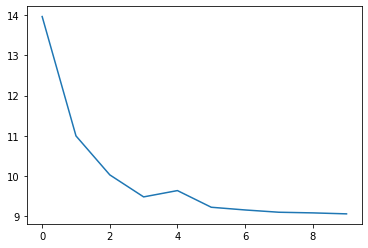

In [38]:
total_hists =  resultsa[0] 
# + resultsb[0] 
# + resultsc[0]  + resultsd[0]  + resultse[0]
# + resultse[0]

# + resultsd[0]
total_uncerts = resultsa[1] 

# + resultsb[1]  
# + resultsc[1]  + resultsd[1] + resultse[1]
# + resultse[1]


plt.plot(np.arange(0, len(total_hists)), total_hists)# plot the uncertainties
a_hists = np.array(total_hists)
a_uncerts = np.array(total_uncerts)
plt.fill_between(np.arange(0,len(total_hists)), a_hists - a_uncerts, a_hists + a_uncerts, alpha=.4)
# plt.ylim(0, 25)

plt.show()

In [39]:
save_params(resultsa[3],"3+3_data/g0.pkl")

In [40]:
print(resultsa[0][-1], resultsa[1][-1])

9.064829 0.0013975654


In [41]:
step_size = .45
samples = sample_ar(resultsa[3], 1000, 1000, 5, step_size, progress=True)
print(samples[1])

MC: 100%|██████████| 6001/6001 [00:01<00:00, 3158.04it/s]


0.49425095817363773


In [42]:
g = -.5

resultsb = batch_train(resultsa[3], 10, 200000, 64, 2500, 10, step_size, g)


Energy = 8.050475: 100%|██████████| 10/10 [15:08<00:00, 90.84s/it]


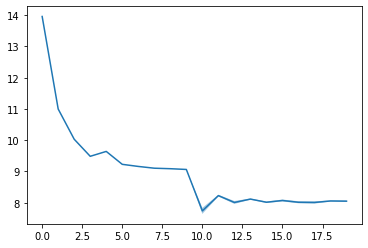

In [43]:
total_hists =  resultsa[0]  + resultsb[0] 
# + resultsc[0]  + resultsd[0]  + resultse[0]
# + resultse[0]

# + resultsd[0]
total_uncerts = resultsa[1]  + resultsb[1]  
# + resultsc[1]  + resultsd[1] + resultse[1]
# + resultse[1]


plt.plot(np.arange(0, len(total_hists)), total_hists)# plot the uncertainties
a_hists = np.array(total_hists)
a_uncerts = np.array(total_uncerts)
plt.fill_between(np.arange(0,len(total_hists)), a_hists - a_uncerts, a_hists + a_uncerts, alpha=.4)
# plt.ylim(0, 25)

plt.show()

In [44]:
save_params(resultsb[3],"3+3_data/g0.5.pkl")

In [45]:
print(resultsb[0][-1], resultsb[1][-1])

8.050475 0.02121133


In [46]:
step_size = .45
samples = sample_ar(resultsb[3], 1000, 1000, 5, step_size, progress=True)
print(samples[1])

MC: 100%|██████████| 6001/6001 [00:01<00:00, 3134.77it/s]


0.5092484585902349


In [47]:
g=-1

resultsc = batch_train(resultsb[3], 10, 200000, 64, 2500, 10, step_size, g)


Energy = 7.0513: 100%|██████████| 10/10 [15:11<00:00, 91.19s/it]  


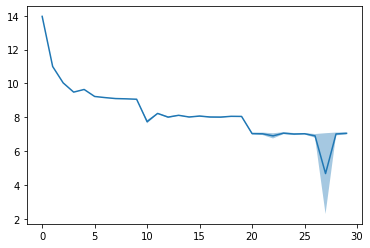

In [48]:
total_hists =  resultsa[0]  + resultsb[0] + resultsc[0] 
# + resultsd[0]  + resultse[0]
# + resultse[0]

# + resultsd[0]
total_uncerts = resultsa[1]  + resultsb[1]  + resultsc[1] 
# + resultsd[1] + resultse[1]
# + resultse[1]


plt.plot(np.arange(0, len(total_hists)), total_hists)# plot the uncertainties
a_hists = np.array(total_hists)
a_uncerts = np.array(total_uncerts)
plt.fill_between(np.arange(0,len(total_hists)), a_hists - a_uncerts, a_hists + a_uncerts, alpha=.4)
# plt.ylim(0, 25)

plt.show()

In [49]:
save_params(resultsc[3],"3+3_data/g1.pkl")

In [50]:
print(resultsc[0][-1], resultsc[1][-1])

7.0513 0.06078939


In [51]:
step_size = .42
samples = sample_ar(resultsc[3], 1000, 1000, 5, step_size, progress=True)
print(samples[1])

MC: 100%|██████████| 6001/6001 [00:01<00:00, 3165.21it/s]


0.5150808198633561


In [52]:
g=-1.5

resultsd = batch_train(resultsc[3], 5, 200000, 64, 2500, 10, step_size, g)


Energy = 5.768483: 100%|██████████| 5/5 [07:36<00:00, 91.25s/it] 


In [61]:
resultse = batch_train(resultsd[3], 5, 350000, 64, 5000, 10, step_size, g)

Energy = 5.741515: 100%|██████████| 5/5 [11:23<00:00, 136.62s/it] 


In [65]:
resultsf = batch_train(resultse[3], 50, 400000, 64, 5000, 10, step_size, g)

Energy = 5.724622: 100%|██████████| 50/50 [2:06:36<00:00, 151.92s/it]   


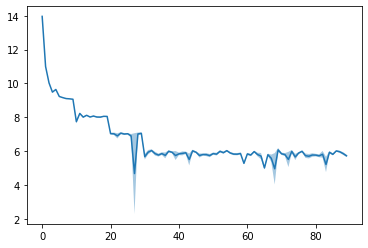

In [66]:
total_hists =  resultsa[0]  + resultsb[0] + resultsc[0] + resultsd[0]+ resultse[0] + resultsf[0]
# + resultse[0]

# + resultsd[0]
total_uncerts = resultsa[1]  + resultsb[1]  + resultsc[1]  + resultsd[1] +resultse[1] + resultsf[1]
# + resultse[1]
# + resultse[1]


plt.plot(np.arange(0, len(total_hists)), total_hists)# plot the uncertainties
a_hists = np.array(total_hists)
a_uncerts = np.array(total_uncerts)
plt.fill_between(np.arange(0,len(total_hists)), a_hists - a_uncerts, a_hists + a_uncerts, alpha=.4)
# plt.ylim(0, 25)

plt.show()

In [67]:
save_params(resultsf[3],"3+3_data/g1.5.pkl")

In [70]:
print(resultsf[0][-3], resultsf[1][-3])

5.9641843 0.06284591
